# 1. INIT - Import packages

In [1]:
import os
import sys
from pathlib import Path

# --- Start of the robust path modification ---
try:
    # This variable is defined in VS Code notebooks
    current_file_path = Path(__vsc_ipynb_file__)
except NameError:
    # Fallback for other environments or .py scripts
    current_file_path = Path.cwd()

# Traverse up to find the project root
# We assume the project root contains a known directory, e.g., 'Deps' or a marker file like '.git'
project_root = current_file_path
while not (project_root / 'Deps').exists() and project_root.parent != project_root:
    project_root = project_root.parent

# Add project root to the Python path if it's not already there
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"Project Root: {project_root}")
print(f"Current Working Directory: {os.getcwd()}")

import torch
from torch import nn
from torch.nn import functional as F
from A01_ImageNet import model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print('Pytorch version :', torch.__version__)
print('CUDA version\t:', torch.version.cuda)
print('GPU\t\t:',torch.cuda.get_device_name())

Project Root: /workspace
Current Working Directory: /workspace/A02_Semantic_Analysis
Pytorch version : 2.0.1+cu117
CUDA version	: 11.7
GPU		: NVIDIA A40


# 2. INIT - Transformations

In [2]:
# ImageNet1k train
mean_imagenet1k_train = [0.485, 0.456, 0.406]
std_imagenet1k_train = [0.229, 0.224, 0.225]

transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_imagenet1k_train, std=std_imagenet1k_train)
])

transform_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_imagenet1k_train, std=std_imagenet1k_train)
])

# 3. SETTINGS - Adjust here!
Example candidate figures in the article Fig2b
| which images | label choice 1 | label choice 2 | label choice 3 | 
| :--- | :--- | :--- | :--- |
| img1 from category `Tench` | `0` for Tench | `837` for Sunglasses | `621` for Bucket |
| img2 from category `Lifeboat` | `625` for Lifeboat | `425` for Barn | `460` for Seawall |
| [img3](https://www.publicdomainpictures.net/en/view-image.php?image=474516&picture=orange-ship-lifeboat) from Public Domain Pictures under CC0 | `625` for Lifeboat | `978` for Seashore | `0` for Tench |



In [88]:
img1 = Image.open(os.path.join(project_root, 'Deps', 'CAM_fig', 'fig1.JPEG')).convert('RGB')
label1 = 0 # 837, 621

img2 = Image.open(os.path.join(project_root, 'Deps', 'CAM_fig', 'fig2.JPEG')).convert('RGB')
label2 = 625 # 425, 460

img3 = Image.open(os.path.join(project_root, 'Deps', 'CAM_fig', 'fig3.jpg')).convert('RGB')
label3 = 625 # 978, 0

img = transform_val(img3)
label = 978

print(img.shape, label)

torch.Size([3, 224, 224]) 978


# 4. Grad-CAM plot

torch.Size([1, 2048, 7, 7])
torch.Size([2048])


/tmp/ipykernel_6952/2589612544.py:62: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  cam_img = np.uint8(Image.fromarray(cam_img).resize((224, 224), Image.ANTIALIAS))


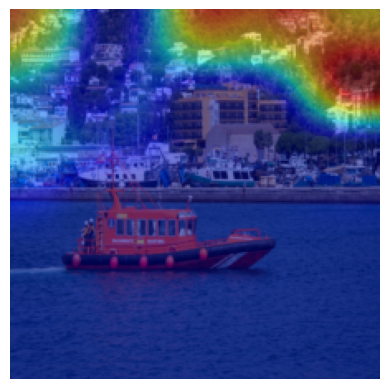

In [87]:
net_idx = 22
net = model.cats_net(symbol_size = 20, num_classes = 1000, fix_fe = False, fe_type = 'resnet50')
net.load_state_dict(
    torch.load(
        os.path.join(
            project_root, 
            'Results', 
            'param', 
            f'imagenet1k_ss20_fixfe_resnet50_mlp3_hidden100_initrandom_trail{net_idx}.pt'
        )
    ), 
    strict = False
)
net.to('cuda')
net.eval()

input_batch = img.unsqueeze(0).to('cuda')

# print(img.shape)
# print(input_batch.shape)

ca_afun = nn.Sigmoid()

gating_list = []
features_list = []
grad_list = []

def hook_feature(module, input, output):
    features_list.append(output.cpu().data)

def hook_grad(module, grad_input, grad_output):
    grad_list.append(grad_output[0].cpu().data)

def hook_gating(module, input, output):
    tmp = ca_afun(output)
    gating_list.append(tmp.cpu().data)

finalconv_name = 'layer4'
forward_hook = net.fe._modules.get(finalconv_name)[2].register_forward_hook(hook_feature)
backward_hook = net.fe._modules.get(finalconv_name)[2].register_full_backward_hook(hook_grad)
gating_hook = net.ca_bn1.register_forward_hook(hook_gating)

output = net(input_batch, net.symbol_set[label].unsqueeze(0))

output[0, 1].backward()

gating = gating_list[0].squeeze()
print(grad_list[0].shape)
pooled_grad = torch.mean(grad_list[0], dim = [0, 2, 3])
print(pooled_grad.shape)

for i in range(features_list[0].size()[1]):
    features_list[0][:, i, :, :] *= pooled_grad[i] * gating[i]

feature_map = F.relu(torch.sum(features_list[0].reshape(2048, 7*7), dim = [0])).cpu().numpy()
# print(feature_map.shape)

cam = feature_map.reshape(7, 7)
cam = cam - np.min(cam)
cam_img = cam / np.max(cam)
cam_img = np.uint8(255 * cam_img)
cam_img = np.uint8(Image.fromarray(cam_img).resize((224, 224), Image.ANTIALIAS))

input_img = img.permute(1, 2, 0).numpy()
input_img = (input_img - input_img.min()) / (input_img.max() - input_img.min())

plt.imshow(input_img)
plt.imshow(cam_img, cmap='jet', alpha=0.5)
plt.axis(False)
plt.show()